In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, RandomSampler
import torchvision as vision
import cv2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
import pandas as pd
from tqdm import tqdm

from random import shuffle, randint
from copy import deepcopy
from pathlib import Path

from sklearn.metrics import f1_score
import albumentations as A
from torchvision.models import resnet50, ResNet50_Weights

sns.set()

In [2]:
def transform_df_to_dict(df):
    d = {}
    for _, row in df.iterrows():
        d[row["path"]] = row["label"]
    return d

In [3]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(DEVICE)
DATA_PATH = Path("/mnt/ssd/kaggle_bee_vs_wasp/")
df = pd.read_csv(DATA_PATH / "labels.csv")
df.path = df.path.apply(lambda x: x.split("\\")[1])
# Take only quality images TODO


train_images = transform_df_to_dict(df[(df.is_validation + df.is_final_validation) == 0])
valid_images = transform_df_to_dict(df[df.is_validation == 1])
test_images = transform_df_to_dict(df[df.is_final_validation == 1])
print(len(train_images), len(valid_images), len(test_images))

cuda
7937 1719 1763


# Датасет и нейросеть
Для данной задачи классификации в качестве первого эксперимента используем простой вариант сверточной нейросети (класс SimpleCNN), состоящей из нескольких блоков. Размер ядра = 3. Функция `create_cnn_block` создает блоки нейросети.
Метки классов: 
   0 - bee, 
   1 - wasp,
   2 - insect,
   3 - other.

In [4]:
def create_cnn_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.MaxPool2d(2),
            nn.ReLU(),
    )

class SimpleCNN(nn.Module):

    def __init__(self, dropout):
        super().__init__()
        self.net = nn.Sequential(
            create_cnn_block(3, 8),
            create_cnn_block(8, 16),
            create_cnn_block(16, 32),
            create_cnn_block(32, 64),
            create_cnn_block(64, 64),
            create_cnn_block(64, 64),
            nn.Dropout(dropout)
        )
        self.out = nn.Linear(768, 4)

    def forward(self, x):
        emb = self.net(x)
        emb = emb.view(emb.size(0), -1)
        return self.out(emb)

class BeesDataset(Dataset):

    def __init__(self, folder_with_images: str, image_names: "dict", resize: tuple = (400, 360), transforms=None):
        self.transforms = transforms
        self.class_to_label = {"bee": 0, "wasp": 1, "insect": 2, "other": 3}
        self.X = []
        self.y = []
        for path in Path(folder_with_images).rglob("*"):
            if path.name in image_names:
                image = cv2.imread(str(path))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, resize, interpolation=cv2.INTER_LINEAR)
                self.X.append(image)
                self.y.append(self.class_to_label[image_names[path.name]])

    def __getitem__(self, index):
        # Permute h, w, c -> c, h, w
        x = self.X[index]
        if self.transforms is not None:
            x = self.transforms(image=x)["image"]
        x = torch.FloatTensor(x / 255).permute(2, 0, 1)
        return x, self.y[index]

    def __len__(self):
        return len(self.X)

    def extend_with_augmentations(self, iterations):
        original_size = len(self)
        for iteration in range(iterations):
            for idx in range(original_size):
                image = self.X[idx]
                y = self.y[idx]
                new_image = TRANSFORM(image=image)["image"]
                self.X.append(new_image)
                self.y.append(y)

In [5]:
train_dataset = BeesDataset(DATA_PATH, train_images)
val_dataset = BeesDataset(DATA_PATH, valid_images)
test_dataset = BeesDataset(DATA_PATH, test_images)

In [6]:
BATCH_SIZE = 128
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, sampler=RandomSampler(train_dataset))
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, sampler=RandomSampler(val_dataset))

# Функции для обучения нейросети и получения предсказаний
В функции обучения train можно задать параметр для l2 регуляризации (weight_decay в оптимизаторе Adam).
Функция обучения train сохраняет веса моделей и отслеживает по эпохам значения функции потерь и метрики F1-score. 

В обучение встроен механизм early stopping: обучение останавливается, если прошло 5 (константа STALE_EPOCHS) эпох обучения без улучшения F1-score на валидационной выборке. 

Функция train возвращает модель, в которую загружены лучшие веса, соответствующие лучшей F1-score на валидации, а также списки с средними значениями функции потерь и F1-score по обучающим и валидационным выборкам по всем пройденным эпохам.

In [7]:
def train(cnn, train_loader, val_loader, l2_reg=0):
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=0.001, weight_decay=l2_reg)
    train_epoch_losses = []
    train_epoch_f1 = []
    eval_epoch_losses = []
    eval_epoch_f1 = []
    best_f1 = 0
    best_f1_epoch = 0
    epochs_without_improvement = 0
    STALE_EPOCHS = 5
    EPOCHS = 50
    for epoch in range(EPOCHS):
        losses = []
        # Train
        preds = []
        true = []
        cnn = cnn.train()
        for i, batch in tqdm(enumerate(train_loader)):
            x, y = batch
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            y_pred = cnn(x)
            loss = loss_func(y_pred, y)
            preds.append(y_pred.argmax(1).detach().cpu().tolist())
            true.append(y.detach().cpu().tolist())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss.item())

        train_epoch_losses.append(sum(losses) / len(losses))
        true = sum(true, [])
        preds = sum(preds, [])
        train_epoch_f1.append(f1_score(true, preds, average=None))
        print(f"Train epoch {epoch}: loss = {train_epoch_losses[-1]}, f1 = {np.mean(train_epoch_f1[-1])}")
        # print("Train", correct, total)
        # Validation
        losses = []
        total = 0
        correct = 0
        cnn = cnn.eval()
        preds = []
        true = []
        with torch.no_grad():
            for i, batch in enumerate(val_loader):
                x, y = batch
                x = x.to(DEVICE)
                y = y.to(DEVICE)
                y_pred = cnn(x)
                loss = loss_func(y_pred, y)    
                losses.append(loss.item())
                preds.append(y_pred.argmax(1).cpu().tolist())
                true.append(y.cpu().tolist())
        
        eval_epoch_losses.append(sum(losses) / len(losses))
        true = sum(true, [])
        preds = sum(preds, [])
        eval_epoch_f1.append(f1_score(true, preds, average=None))
        macro_f1 = sum(eval_epoch_f1[-1]) / len(eval_epoch_f1[-1])
        print(f"Eval epoch {epoch}: loss = {eval_epoch_losses[-1]}, f1 = {np.mean(eval_epoch_f1[-1])}")
        if macro_f1 > best_f1:
            print(f"Improved on epoch {epoch} scored {np.mean(eval_epoch_f1[-1])} vs {best_f1}")
            best_f1 = macro_f1
            epochs_without_improvement = 0
            best_f1_epoch = epoch
            torch.save(cnn.state_dict(), "cnn_best.pt")
        else:
            epochs_without_improvement += 1
        
        if epochs_without_improvement >= STALE_EPOCHS:
            break
    
    cnn.load_state_dict(torch.load("cnn_best.pt"))
    print("Trained for", epoch, "epochs, best epoch is", best_f1_epoch, "macro f1", best_f1)
    return cnn, train_epoch_losses, eval_epoch_losses, train_epoch_f1, eval_epoch_f1


def predict_on_dataset(model, dataset, batch_size=BATCH_SIZE):
    model.eval()
    preds_all = []
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            preds = model(x).argmax(dim=1).tolist()
        preds_all += preds
    return preds_all


def plot_loss_and_f1(train_epoch_losses, eval_epoch_losses, train_epoch_f1, eval_epoch_f1):
    fig, axes = plt.subplots(3, 2, figsize=(15, 10))
    ax = axes[0][0]
    ax.set_title("Loss")
    ax.plot(train_epoch_losses, label="Train")
    ax.plot(eval_epoch_losses, label="Eval")
    ax.legend()
    train_f1 = np.array(train_epoch_f1)
    eval_f1 = np.array(eval_epoch_f1)
    
    
    ax = axes[0][1]
    ax.set_title("Macro F1")
    ax.plot(train_f1.mean(axis=1), label="Train")
    ax.plot(eval_f1.mean(axis=1), label="Eval")
    ax.legend()
    
    
    ax = axes[1][0]
    ax.set_title("Bee F1")
    ax.plot(train_f1[:, 0], label="Train")
    ax.plot(eval_f1[:, 0], label="Eval")
    ax.legend()
    
    
    ax = axes[1][1]
    ax.set_title("Wasp F1")
    ax.plot(train_f1[:, 1], label="Train")
    ax.plot(eval_f1[:, 1], label="Eval")
    ax.legend()
    
    ax = axes[2][0]
    ax.set_title("Insect F1")
    ax.plot(train_f1[:, 2], label="Train")
    ax.plot(eval_f1[:, 2], label="Eval")
    ax.legend()
    
    ax = axes[2][1]
    
    ax.set_title("Other F1")
    ax.plot(train_f1[:, 3], label="Train")
    ax.plot(eval_f1[:, 3], label="Eval")
    ax.legend()
 

# Базовое обучение
Обучим простую сверточную нейросеть (SimpleCNN) без регуляризации, дропаута и аугментаций данных.

63it [00:17,  3.63it/s]


Train epoch 0: loss = 0.8256553553399586, f1 = 0.6082549536921528
Eval epoch 0: loss = 0.6878539834703717, f1 = 0.7060452841211082
Improved on epoch 0 scored 0.7060452841211082 vs 0


63it [00:15,  3.97it/s]


Train epoch 1: loss = 0.5946924809425597, f1 = 0.7486001005073787
Eval epoch 1: loss = 0.5833785853215626, f1 = 0.7687711196826076
Improved on epoch 1 scored 0.7687711196826076 vs 0.7060452841211082


63it [00:23,  2.72it/s]


Train epoch 2: loss = 0.5149270925256941, f1 = 0.8004258776303621
Eval epoch 2: loss = 0.6078058161905834, f1 = 0.6984131241398359


63it [00:16,  3.89it/s]


Train epoch 3: loss = 0.49182653569039847, f1 = 0.8120524126128976
Eval epoch 3: loss = 0.5661661007574627, f1 = 0.7535621195011426


63it [00:16,  3.91it/s]


Train epoch 4: loss = 0.4364107657992651, f1 = 0.8352803652433458
Eval epoch 4: loss = 0.864233272416251, f1 = 0.6476083600569037


63it [00:15,  4.15it/s]


Train epoch 5: loss = 0.3862435519695282, f1 = 0.8566775234941117
Eval epoch 5: loss = 0.5582323798111507, f1 = 0.7852219584724243
Improved on epoch 5 scored 0.7852219584724243 vs 0.7687711196826076


63it [00:22,  2.81it/s]


Train epoch 6: loss = 0.3606463506344765, f1 = 0.865259234270534
Eval epoch 6: loss = 0.5611271070582526, f1 = 0.7702365649921089


63it [00:18,  3.40it/s]


Train epoch 7: loss = 0.3093707440864472, f1 = 0.8919648633961864
Eval epoch 7: loss = 0.4700457070555006, f1 = 0.8347936490563104
Improved on epoch 7 scored 0.8347936490563104 vs 0.7852219584724243


63it [00:15,  4.13it/s]


Train epoch 8: loss = 0.3241075717267536, f1 = 0.8785326581108349
Eval epoch 8: loss = 1.0953883699008398, f1 = 0.5857860913235764


63it [00:17,  3.50it/s]


Train epoch 9: loss = 0.3011918060836338, f1 = 0.8930718941263793
Eval epoch 9: loss = 0.5646527260541916, f1 = 0.789975653297406


63it [00:21,  2.89it/s]


Train epoch 10: loss = 0.2691785865832889, f1 = 0.8977590499834367
Eval epoch 10: loss = 0.8598711277757373, f1 = 0.7330588288751247


63it [00:17,  3.53it/s]


Train epoch 11: loss = 0.21984355470963887, f1 = 0.9223562623147079
Eval epoch 11: loss = 0.7310535609722137, f1 = 0.7446306262259521


63it [00:15,  3.98it/s]


Train epoch 12: loss = 0.1918801192253355, f1 = 0.9353088275109236
Eval epoch 12: loss = 0.5548755994864872, f1 = 0.8043863607565892
Trained for 12 epochs, best epoch is 7 macro f1 0.8347936490563104
Best macro f1: 0.8347936490563104


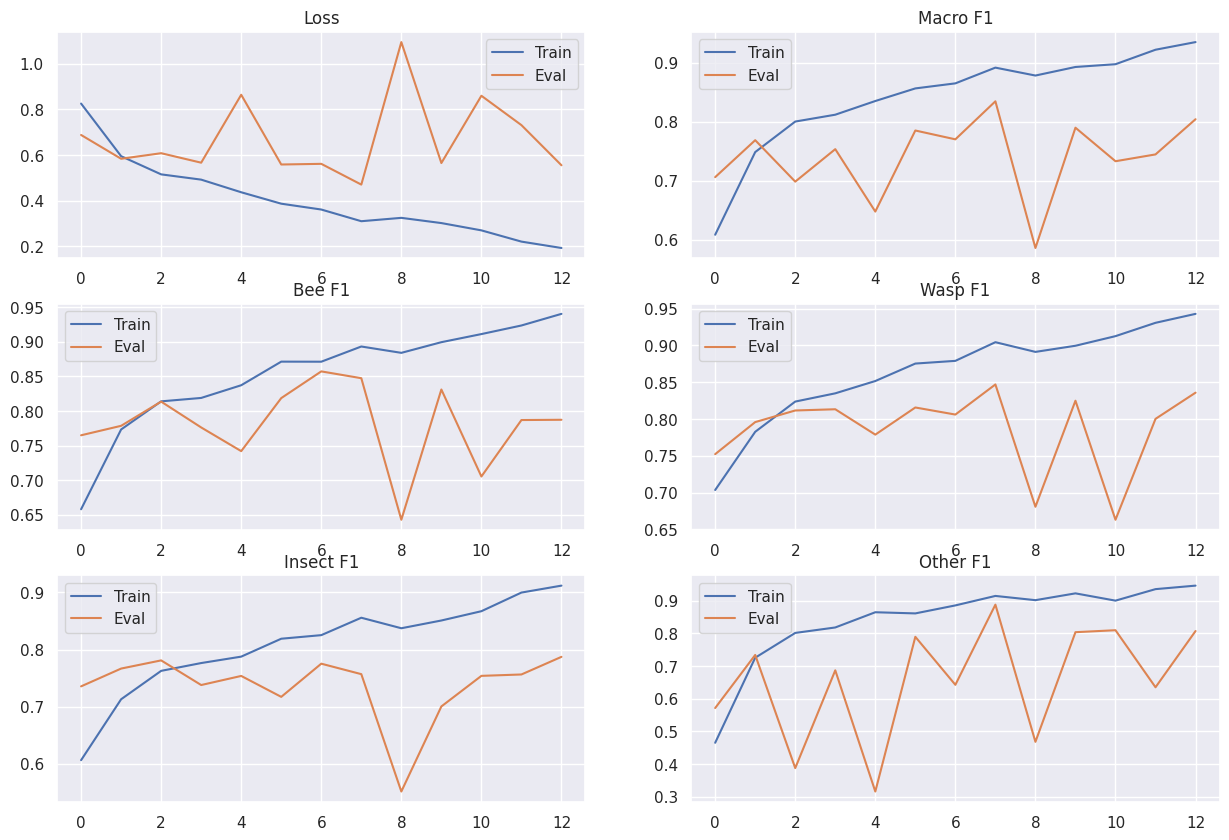

In [8]:
cnn = SimpleCNN(dropout=0).to(DEVICE).train()
cnn, train_epoch_losses, eval_epoch_losses, train_epoch_f1, eval_epoch_f1 = train(cnn, train_loader, val_loader)
plot_loss_and_f1(train_epoch_losses, eval_epoch_losses, train_epoch_f1, eval_epoch_f1)
print(f"Best macro f1: {np.max(np.mean(eval_epoch_f1, axis=1))}")

# Обучение с дропаутом и регуляризацией
Добавим нашей нейросети dropout = 0.2 и weight decay.

63it [00:25,  2.46it/s]


Train epoch 0: loss = 0.8665381045568556, f1 = 0.588238084405029
Eval epoch 0: loss = 0.7807620891502925, f1 = 0.5720129417565337
Improved on epoch 0 scored 0.5720129417565337 vs 0


63it [00:18,  3.43it/s]


Train epoch 1: loss = 0.6215047613968925, f1 = 0.7455337798340349
Eval epoch 1: loss = 0.6462188448224749, f1 = 0.7314696224464002
Improved on epoch 1 scored 0.7314696224464002 vs 0.5720129417565337


63it [00:14,  4.20it/s]


Train epoch 2: loss = 0.5870371068280841, f1 = 0.7749213227621391
Eval epoch 2: loss = 0.7988312585013253, f1 = 0.6578241030231247


63it [00:15,  4.07it/s]


Train epoch 3: loss = 0.5586488795658898, f1 = 0.7803946441272644
Eval epoch 3: loss = 0.5411856727940696, f1 = 0.8047865335717023
Improved on epoch 3 scored 0.8047865335717023 vs 0.7314696224464002


63it [00:21,  2.88it/s]


Train epoch 4: loss = 0.47412039315889754, f1 = 0.815858603277486
Eval epoch 4: loss = 0.7148767752306802, f1 = 0.6357285278891284


63it [00:21,  2.96it/s]


Train epoch 5: loss = 0.4624767237239414, f1 = 0.821108079909379
Eval epoch 5: loss = 0.5751392458166394, f1 = 0.769050910336504


63it [00:14,  4.30it/s]


Train epoch 6: loss = 0.433659632527639, f1 = 0.8328711431959687
Eval epoch 6: loss = 0.6484461384160178, f1 = 0.7209709310228322


63it [00:20,  3.09it/s]


Train epoch 7: loss = 0.3970490514285981, f1 = 0.8503241200474588
Eval epoch 7: loss = 0.6566877109663827, f1 = 0.7458001758448729


63it [00:15,  4.05it/s]


Train epoch 8: loss = 0.40384275809166925, f1 = 0.8467742496920305
Eval epoch 8: loss = 0.5786885917186737, f1 = 0.7991822889947211
Trained for 8 epochs, best epoch is 3 macro f1 0.8047865335717023
Best macro f1: 0.8047865335717023


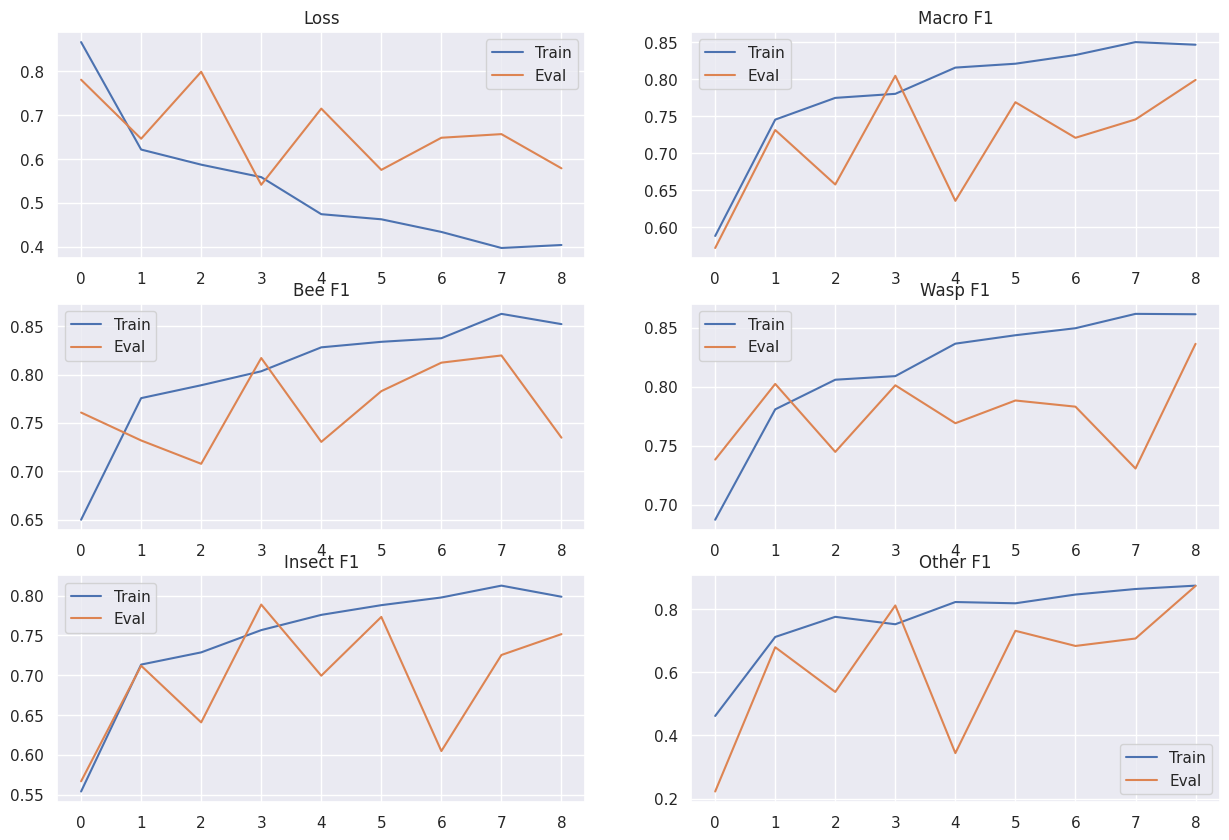

In [9]:
cnn = SimpleCNN(dropout=0.2).to(DEVICE).train()
cnn, train_epoch_losses, eval_epoch_losses, train_epoch_f1, eval_epoch_f1 = train(cnn, train_loader, val_loader, 0.01)
plot_loss_and_f1(train_epoch_losses, eval_epoch_losses, train_epoch_f1, eval_epoch_f1)
print(f"Best macro f1: {np.max(np.mean(eval_epoch_f1, axis=1))}")

# Resnet
Возьмем веса предобученной модели ResNet и попробуем дообучить ее для нашей задачи, предварительно приведя картинки к нужному формату.

125it [00:39,  3.15it/s]


Train epoch 0: loss = 0.5080232642889023, f1 = 0.8056625657247721
Eval epoch 0: loss = 0.4386257777611415, f1 = 0.8651221654001726
Improved on epoch 0 scored 0.8651221654001726 vs 0


125it [00:39,  3.14it/s]


Train epoch 1: loss = 0.33829152822494507, f1 = 0.8768776585997593
Eval epoch 1: loss = 0.4568372103903029, f1 = 0.8301866055635168


125it [00:39,  3.14it/s]


Train epoch 2: loss = 0.3597415155172348, f1 = 0.8717990044562298
Eval epoch 2: loss = 0.34703809519608814, f1 = 0.8618771586773971


125it [00:39,  3.14it/s]


Train epoch 3: loss = 0.29310934937000277, f1 = 0.8953481245932176
Eval epoch 3: loss = 0.41585327960826735, f1 = 0.8522455673518533


125it [00:39,  3.14it/s]


Train epoch 4: loss = 0.25291412842273714, f1 = 0.9149426893128477
Eval epoch 4: loss = 0.35699038759425833, f1 = 0.8634693812869951


125it [00:39,  3.13it/s]


Train epoch 5: loss = 0.20954019251465797, f1 = 0.9245852585947059
Eval epoch 5: loss = 0.6909636899277016, f1 = 0.7704243648727169
Trained for 5 epochs, best epoch is 0 macro f1 0.8651221654001726
Best macro f1: 0.8651221654001726


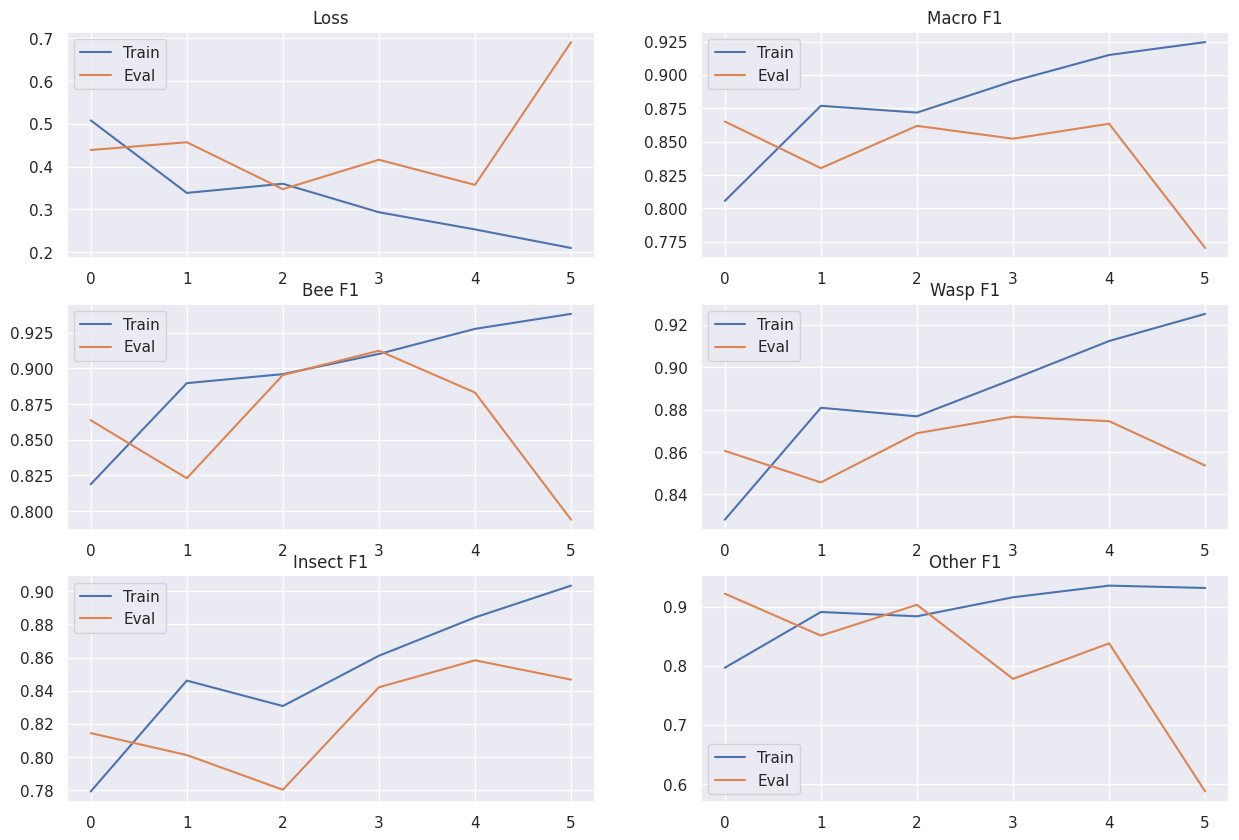

In [11]:
weights = ResNet50_Weights.IMAGENET1K_V1
resnet = resnet50(weights=weights)
resnet.fc = nn.Linear(2048, 4)
resnet = resnet.to(DEVICE)
transforms = A.Compose(
    [
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)
train_dataset.transforms = transforms
val_dataset.transforms = transforms
BATCH_SIZE = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, sampler=RandomSampler(train_dataset), num_workers=3)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, sampler=RandomSampler(val_dataset))

resnet, train_epoch_losses, eval_epoch_losses, train_epoch_f1, eval_epoch_f1 = train(resnet, train_loader, val_loader)
plot_loss_and_f1(train_epoch_losses, eval_epoch_losses, train_epoch_f1, eval_epoch_f1)
print(f"Best macro f1: {np.max(np.mean(eval_epoch_f1, axis=1))}")

# Выбор лучшей модели и оценка качества
Лучшее качество на валидационной выборке у модели ResNet, поэтому выберем ее для оценки качества предсказаний на тестовой выборке.

In [12]:
test_dataset.transforms = transforms
predictions = predict_on_dataset(resnet, test_dataset)
f1 = f1_score(test_dataset.y, predictions, average=None)
print("TEST DATA RESULTS")
print(f1)
print(np.mean(f1))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.51it/s]

TEST DATA RESULTS
[0.85687023 0.83547926 0.80582524 0.9       ]
0.8495436819515487
